In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
sys.path.append("..")
sys.path.append("../local_train/")

In [13]:
import pyro.distributions as dist

In [3]:
os.environ['CUDA_VISIBLE_DEVICES']= '0'
os.environ['LIBRARY_PATH'] = '/usr/local/cuda/lib64'

In [4]:
from model import YModel, OptLoss
from pyDOE import lhs
from collections import defaultdict
from scipy.spatial.distance import cosine
from tqdm import tqdm
from local_train.gan_nets import Generator, Discriminator #WSDiscriminator, GANLosses
from local_train.gan_model import GANModel

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch

import numpy as np
from tqdm import trange

import matplotlib.pyplot as plt
import seaborn as sns


device = torch.device("cuda", 0)


from collections import defaultdict
%matplotlib inline

In [5]:
from comet_ml import API
import comet_ml
import io

comet_api = API()
comet_api.get()

['shir994']

In [6]:
exps = comet_api.get("shir994/10d-grads")
# hyper_params = {}
# for param in exp.parameters:
#     hyper_params[param["name"]] = param["valueMin"]

In [7]:
# import io

# #asset_id = [exp_a['assetId'] for exp_a in exp.asset_list if exp_a['fileName'] == f"{hyper_params['data_size']}_999.tar"][0]
# asset_id = [exp_a['assetId'] for exp_a in exp.asset_list if exp_a['fileName'] == "0.tar"][0]
# params = exp.get_asset(asset_id)
# state_dict = torch.load(io.BytesIO(params))

In [8]:
experiments = {}
for exp in exps:
    hyper_params = {}
    for param in exp.parameters:
        hyper_params[param["name"]] = param["valueMin"]
    experiments[hyper_params["num_epochs"] + "_" + hyper_params["run_arg_9"]] = {}
    experiments[hyper_params["num_epochs"] + "_" + hyper_params["run_arg_9"]]["params"] = hyper_params
    
    asset_id = [exp_a['assetId'] for exp_a in exp.asset_list if exp_a['fileName'] == "0.tar"][0]
    params = exp.get_asset(asset_id)
    
    experiments[hyper_params["num_epochs"] + "_" + hyper_params["run_arg_9"]]["weights"] = \
                                                                                torch.load(io.BytesIO(params),
                                                                                           map_location='cpu')["gen_state_dict"]

In [9]:
generator = Generator(50, out_dim=1, hidden_dim=100, X_dim=1, psi_dim=10).to(device)
generator.load_state_dict(experiments["20_3.5"]["weights"])

In [83]:
current_psi = torch.Tensor([3.5] * 10).to(device)
#step = 2
average_size = 3000
psi_size = 1000
psi_dim = 10
train_step = 2

y_sampler = YModel(device, current_psi)

In [84]:
def plot_distr(ax):
    for plot_in, step in zip([True, False], [2, 6]):
        print(step, plot_in)
        psi_range = (current_psi - step, current_psi + step)        

        psi_grid = dist.Uniform(*psi_range).sample([psi_size]).to(device)
        #x = y_sampler.x_dist.sample([average_size * psi_size, 1]).to(device)
#         psi_range = torch.tensor(lhs(len(current_psi), psi_size)).float().to(device)
#         scale = 1 if plot_in else scale_step
#         psi_grid = scale * train_step * (psi_range * 2 - 1) + current_psi.view(1, -1)        
        x = y_sampler.sample_x(average_size * psi_size).to(device)

        psi = psi_grid.repeat(1, average_size).view(-1, len(psi_range[0]))
        psi.requires_grad = True
        y_sampler.make_condition_sample({"mu": psi, "x": x})


        data_gen = y_sampler.condition_sample(1)
        true_loss = OptLoss.SigmoidLoss(data_gen, 5, 10).view(-1, average_size).mean(dim=1)
        true_loss.sum().backward(retain_graph=True)
        true_grads = psi.grad.view(-1, 1).view(psi_size, average_size, psi_dim).mean(dim=1)
        true_grads = true_grads.detach()#.cpu().numpy()
        psi.grad.zero_()


        fixed_noise = torch.randn(psi.shape[0], 50).to(device)
        data_gen = generator(fixed_noise, torch.cat([psi, x], dim=1))
        gan_loss = OptLoss.SigmoidLoss(data_gen, 5, 10).view(-1, average_size).mean(dim=1)
        gan_loss.sum().backward(retain_graph=False)
        gan_grads = psi.grad.view(-1, 1).view(psi_size, average_size, len(psi_range[0])).mean(dim=1)
        gan_grads = gan_grads.detach()#.cpu().numpy()
        psi.grad.zero_();

        mask_in = ((psi_grid - current_psi).abs() < train_step).all(dim=1)
        mask_out = ~mask_in

        mask = mask_in if plot_in else mask_out
        label = "In train region" if plot_in else "outside" 
        ax[0].hist(((true_loss - gan_loss) / true_loss).detach()[mask].cpu().numpy(), bins=50, alpha=0.5,
                 label=label);
        ax[0].set_ylabel("a.u.")
        ax[0].set_ylabel("Relative loss diff")
        ax[0].set_title("Epochs: {}, starting point: {}".format(n_epochs, init_psi))
        ax[1].hist(1 - torch.nn.CosineSimilarity(dim=1, eps=1e-32)(true_grads, gan_grads)\
                 .detach()[mask].cpu().numpy(), bins=50, alpha=0.5, label=label);
        ax[1].set_ylabel("a.u.")
        ax[1].set_ylabel("Grads cosine distance")
        ax[1].set_title("Epochs: {}, starting point: {}".format(n_epochs, init_psi))        
        torch.cuda.empty_cache()
    ax[0].legend()
    ax[1].legend()

2 True
6 False
2 True
6 False
2 True
6 False
2 True
6 False
2 True
6 False
2 True
6 False
2 True
6 False
2 True
6 False
2 True
6 False


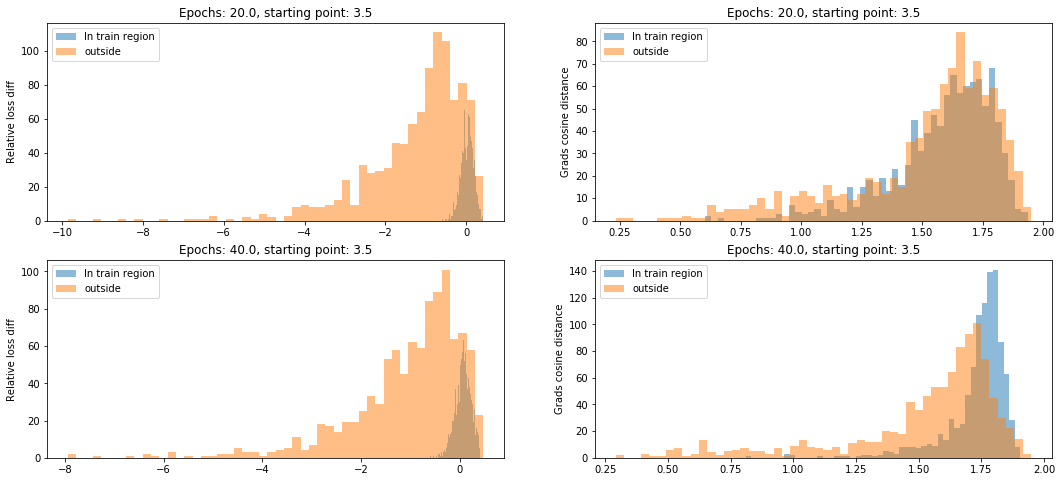

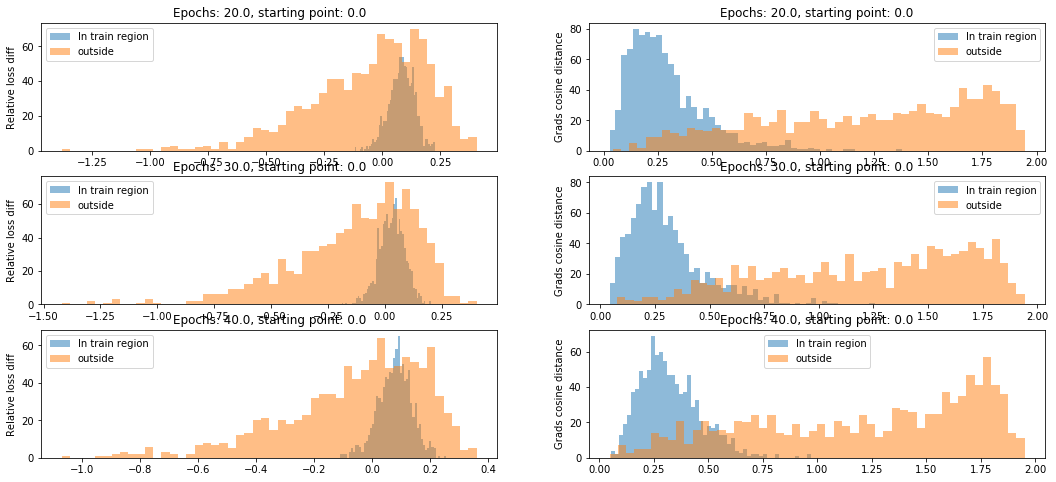

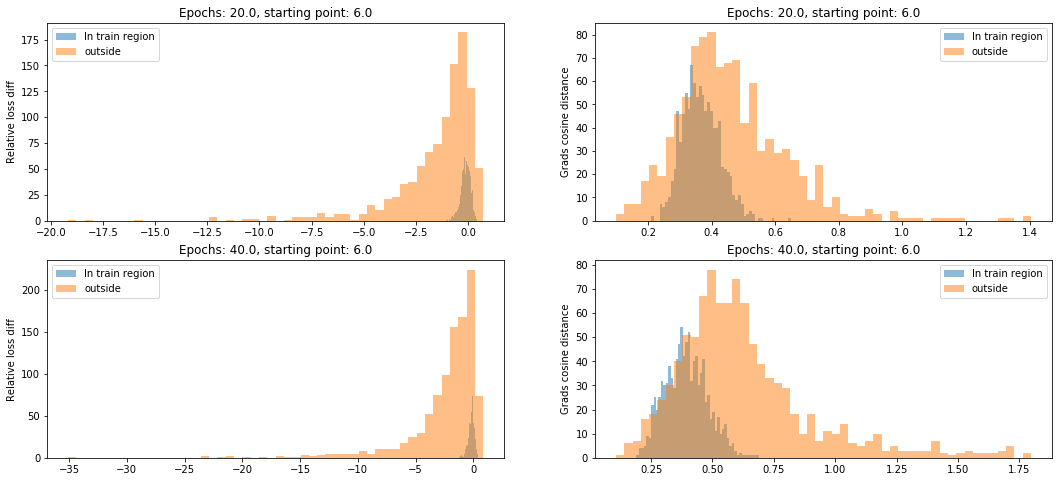

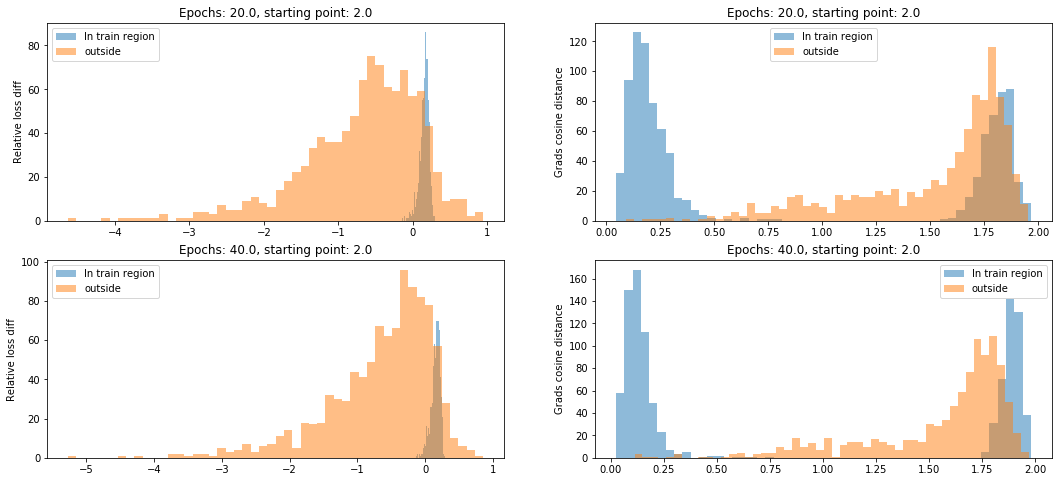

In [85]:
from collections import Counter
counts = Counter(list(map(float, (map(lambda x: x.split("_")[1], experiments.keys())))))
for unique_psi in counts.keys():
    fig, ax = plt.subplots(counts[unique_psi],2, figsize=(18,8))
    iterator = 0
    for key in experiments:
        n_epochs, init_psi = list(map(float, key.split("_")))
        if init_psi == unique_psi:

            generator = Generator(50, out_dim=1, hidden_dim=100, X_dim=1, psi_dim=10).to(device)
            generator.load_state_dict(experiments[key]["weights"])

            current_psi = torch.Tensor([init_psi] * 10).to(device)
            y_sampler = YModel(device, current_psi)
            plot_distr(ax[iterator])
            fig.savefig(str(init_psi) + ".pdf")
            iterator += 1

## calculate using vlad's funcs

In [25]:
gen_model = GANModel(y_sampler, 50, 10, 1, 1, 64, 2, 1, 1, 5, 1)
gen_model._generator.load_state_dict(experiments["20_3.5"]["weights"])

In [26]:
def calc_grad_metric_in_points(oracle, y_sampler, psis, num_repetitions):
    grad_true = y_sampler.grad(psis, num_repetitions=num_repetitions).detach().cpu().numpy()
    grad_fake = oracle.grad(psis, num_repetitions=num_repetitions).detach().cpu().numpy()
    return [cosine(grad_true_i, grad_fake_i)
            for grad_true_i, grad_fake_i in zip(grad_true, grad_fake)]

def calc_func_metric_in_points(oracle, y_sampler, psis, num_repetitions):
    psis = psis.detach().clone().repeat(1, num_repetitions).view(-1, psis.shape[1])
    y_true = y_sampler.func(psis).detach().cpu().numpy()
    y_true = [np.mean(y_true[i * num_repetitions: (i + 1) * num_repetitions])
              for i in range(len(psis) // num_repetitions)]
    y_fake = oracle.func(psis).detach().cpu().numpy()
    y_fake = [np.mean(y_fake[i * num_repetitions: (i + 1) * num_repetitions])
              for i in range(len(psis) // num_repetitions)]
    return ((np.array(y_true) - np.array(y_fake)) / y_true).tolist()


def get_metrics(oracle,
               y_sampler,
               metrics,
               psis,
               current_psi,
               step_data_gen,
               num_repetitions):
    if ((psis - current_psi).abs() < step_data_gen).all().item():
        metrics["grad_metric_inside"].extend(
            calc_grad_metric_in_points(oracle=oracle, y_sampler=y_sampler,
                                            psis=psis, num_repetitions=num_repetitions)
        )
        metrics["func_metric_inside"].extend(
            calc_func_metric_in_points(oracle=oracle, y_sampler=y_sampler,
                                            psis=psis, num_repetitions=num_repetitions)
        )
    else:
        metrics["grad_metric_outside"].extend(
            calc_grad_metric_in_points(oracle=oracle, y_sampler=y_sampler,
                                            psis=psis, num_repetitions=num_repetitions)
        )
        metrics["func_metric_outside"].extend(
            calc_func_metric_in_points(oracle=oracle, y_sampler=y_sampler,
                                           psis=psis, num_repetitions=num_repetitions)
        )

In [27]:
num_samples = 1000 # psi_size
step_data_gen = 2 # train_step
scale_step = 3
num_repetitions = 3000 # average_size

In [86]:
metrics = defaultdict(list)
psi_dim = current_psi.shape[0]  # y_sampler._psi_dim
psis_inside = torch.tensor(lhs(len(current_psi), num_samples)).float().to(device)
psis_inside = step_data_gen * (psis_inside * 2 - 1) + current_psi.view(1, -1)

psis_outside = torch.tensor(lhs(len(current_psi), num_samples)).float().to(device)
psis_outside = scale_step * step_data_gen * (psis_outside * 2 - 1) + current_psi.view(1, -1)

# psis = torch.cat([psis_inside, psis_outside], dim=0)
# chunk_size = 128
# for i in tqdm(range(0, len(psis), chunk_size)):
#     print(i, chunk_size)
#     psis_batch = psis[i:i + chunk_size]
#     get_metrics(oracle=gen_model,
#                            y_sampler=y_sampler,
#                            metrics=metrics,
#                            psis=psis_batch,
#                            current_psi=current_psi,
#                            step_data_gen=step_data_gen,
#                            num_repetitions=num_repetitions)

In [90]:
mask = ((psis_outside - current_psi).abs() < 2).all(dim=1)

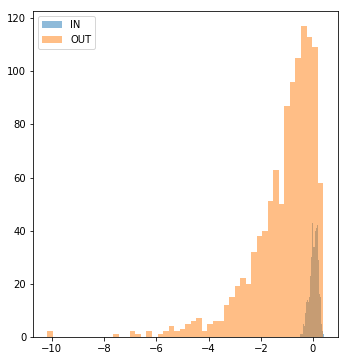

In [30]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.hist(metrics['func_metric_inside'], bins=50, alpha=0.5,
         label="IN");
plt.hist(metrics['func_metric_outside'], bins=50, alpha=0.5,
         label="OUT");
plt.legend()

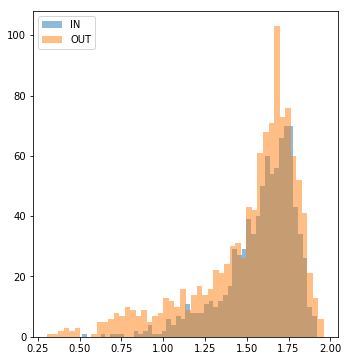

In [33]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.hist(metrics['grad_metric_inside'], bins=50, alpha=0.5,
         label="IN");
plt.hist(metrics['grad_metric_outside'], bins=50, alpha=0.5,
         label="OUT");
plt.legend()